# Step 3 : Modelisation

### Cuase the lack of work in the last two step, the result of modeling is not good.

In [1]:
import pickle 
import pandas as pd 
import numpy as np 
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
SHARED_FOLDER = '../ressources/us_census_full'

In [3]:
with open ('{}/train.csv'.format(SHARED_FOLDER), 'rb') as f:
    train1 = pd.read_csv(f)

with open ('{}/test.csv'.format(SHARED_FOLDER), 'rb') as f:
    test1 = pd.read_csv(f)

with open ('{}/train_cleaned.csv'.format(SHARED_FOLDER), 'rb') as f:
    train = pd.read_csv(f)

with open ('{}/test_cleaned.csv'.format(SHARED_FOLDER), 'rb') as f:
    test = pd.read_csv(f)

with open ('{}/train_income.csv'.format(SHARED_FOLDER), 'rb') as f:
    train_income = pd.read_csv(f)
    
with open ('{}/test_income.csv'.format(SHARED_FOLDER), 'rb') as f:
    target = pd.read_csv(f)

### I don't think that the correlation means that variable has a strong influence in the predictive target because it also depends on the model that we choose so I didn't plot the correlation between variable and the income level. But from the correlation between different variable, we can find like WKSWORK has  a strong correlation with NOEMP so maybe we can delete either but I think it will need more analysis and I'm not sure that's necessary.

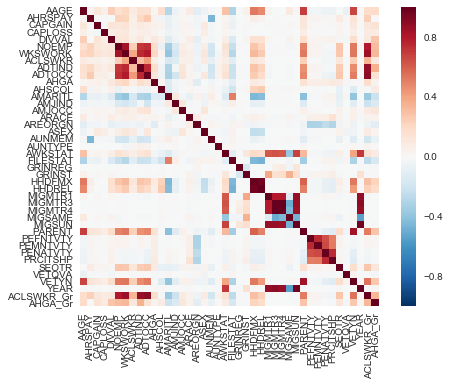

In [4]:
del train['Unnamed: 0'] 
sns.heatmap(train.corr(), square=True)
plt.show()

In [ ]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
train.columns

In [4]:
del train['Unnamed: 0'] 
del test['Unnamed: 0'] 

In [5]:
income_df = pd.DataFrame(index = train.index, columns=["income"])
income_df["income"] = train_income

target_df = pd.DataFrame(index = test.index, columns=["income"])
target_df["income"] = target

In [6]:
all_data = pd.concat((train.loc[:,'AAGE':'AHGA_Gr'], test.loc[:,'AAGE':'AHGA_Gr']))
y = income_df.income
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y)

In [7]:
#####xgboost model##########
import xgboost as xgb

dtrain = xgb.DMatrix(X_train1, label = y_train1)
dtest = xgb.DMatrix(X_test1, label = y_test1)

In [ ]:
###for rmse , pour avoir the best num_boost_round(where it stops)
param = {'bst:max_depth':4, 'bst:eta':0.1}
cv_xgb = xgb.cv(param, dtrain,  num_boost_round=8000, early_stopping_rounds=1000)
cv_xgb[["test-rmse-mean", "train-rmse-mean"]].plot()
plt.show()

In [ ]:
###That's for fixing paremeters of model but I cannot finish it in my ordi cause the function of GridSearchCV need much 
##time and it needs to do the same thing for every paremeter. 
from sklearn.grid_search import GridSearchCV
from xgboost.sklearn import XGBRegressor

param_test1 = {
 'max_depth':[3,4,5,6,7,8,9],
 'min_child_weight':[1,3,5,6]
}

gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=54, max_depth=4, min_child_weight=1, 
                                                 gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
###scikit-learn API#####
#model_xgb = xgb.XGBClassifier(colsample_bytree=0.2, gamma=0.0, max_depth=4, min_child_weight=1.5, learning_rate=0.01, reg_alpha=0.9, 
#                             reg_lambda=0.6, subsample=0.2, seed=42, silent=True, objective='binary:logistic', n_estimators = 7200)
model_xgb = xgb.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators = 400)
model_xgb.fit(X_train1, y_train1)

In [ ]:
preds_xgb = pd.DataFrame({"preds":model_xgb.predict(X_test1), "true":y_test1})
preds_xgb["residuals"] = preds_xgb["true"] - preds_xgb["preds"] 
preds_xgb["residuals"].abs().mean() 
preds_xgb.plot(x = "preds", y = "residuals",kind = "scatter")


In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test1, preds_xgb["preds"], s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

### In fact in the first time, I want to try the LogisticRegression with the code as below but the ordi always block 

In [ ]:
import sklearn.linear_model as linear_model
cls = linear_model.LogisticRegression()
cls.fit(X_train1, y_train1)

In [ ]:
y_pred = cls.predict(X_test1)
cm = metrics.confusion_matrix(y_test1, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=y_test1["Target"].classes_, yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
coefs = pd.Series(cls.coef_[0], index=X_train1.columns)
coefs.sort()       
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

In [ ]:
# for logit regression. 
# statsmodel is chosen because it outputs descriptive stats for the model
import statsmodels.api as sm

logit_train = sm.Logit(y_train1, X_train1) 
result_train = logit_train.fit()

y_test_pred = result_train.predict(X_test1) 
y_test_pred = (y_test_pred > 0.5).astype(int) 
acc = accuracy_score(y_test1, y_test_pred)
auc = roc_auc_score(y_test1, y_test_pred)
